Код для робота (менять не надо): 

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)


In [151]:
class PID_Controller(object):
    def __init__(self, K_p, K_i, K_d, min_val = -np.pi/4, max_val = np.pi/4):
        self.K_i = K_i
        self.K_p = K_p
        self.K_d = K_d
        self.min_val = min_val
        self.max_val = max_val
        
        self.err = None
        self.int = 0
    
    def run(self, robot_coordinates, desired_y, dt):
        x = robot_coordinates[0] # Well, this one is not actually needed in this task
        y = robot_coordinates[1]
        orientation = robot_coordinates[2]
        
        err = desired_y - y
        self.int += err * dt
        
        p_term = self.K_p * err
        # В процессе написания PID controller'a я столкнулся с вот этой проблемой:
        # https://en.wikipedia.org/wiki/Integral_windup
        # 
        # Решаю ее самым простым способом, просто ограничивают значения. Вроде, это относительно
        # неплохо работает (во всяком случае, картики получаются похожими на те, что в википедии)
        i_term = self._clamp(self.K_i * self.int)
        d_term = self.K_d * (0 if self.err is None else (err - self.err)) / dt
        
        self.err = err
        
        return p_term + i_term + d_term

    def _clamp(self, val):
        return sorted([val, self.min_val, self.max_val])[1]

Добавьте вычисление параметра steer через PID controller в этой клетке:

In [154]:
def run(robot, tau_p, tau_d, tau_i, n=200, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    controller = PID_Controller(tau_p, tau_i, tau_d)
    for i in range(n):
        cte = robot.y
        steer = controller.run((robot.x, robot.y, robot.orientation), 0, 0.1)
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory

Запус и отрисовка траектории, тут нужно подобрать оптимальные параметры PID (сейчас стоят 1, 1, 1).

In [171]:
def plot_trajectory(coefs, setpoint=(0, -1, 0)):
    robot = Robot()
    robot.set(setpoint[0], setpoint[1], setpoint[2])

    x_trajectory, y_trajectory = run(robot, coefs[0], coefs[1], coefs[2]) #тут нужно подобрать оптимальные параметры PID.

    plt.plot(x_trajectory, y_trajectory, 'g', label='PID controller')
    plt.plot(x_trajectory, np.zeros(len(x_trajectory)), 'r', label='reference')
    plt.legend()
    plt.show()

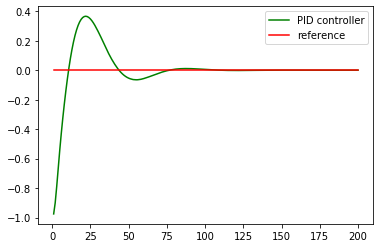

In [172]:
plot_trajectory((1, 1, 1))

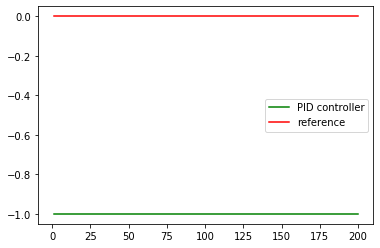

In [177]:
plot_trajectory((0, 1, 0))

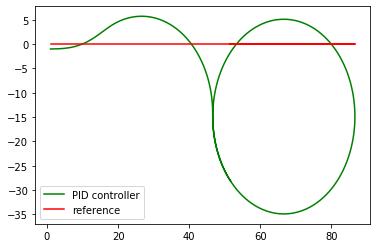

In [175]:
plot_trajectory((0, 0, 1))

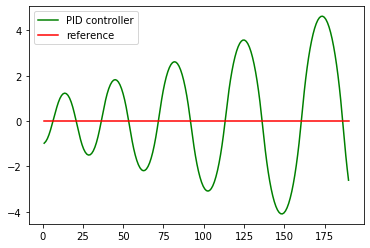

In [176]:
plot_trajectory((1, 0, 0))

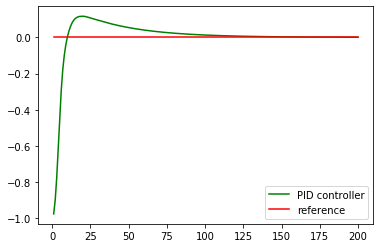

In [178]:
plot_trajectory((2, 1, 0.5))

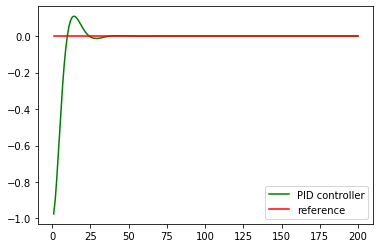

In [173]:
plot_trajectory((1, 0.5, 0))

Вот такие параметры мне показались наиболее оптимальными. Как видно, тут $K_i$ вообще равно 0.